### OpenCV에서 Mask RCNN을 이용하여 Instance Segmentation 수행. 

# GPU가 필요하지 않으며 코랩 커널을 GPU로 바꿀 필요가 없습니다. 
* tensorflow와 keras 설치는 필요하지 않습니다. 

In [1]:
# 현재 디렉토리는 /content이며 이 디렉토리를 기준으로 실습코드와 데이터를 다운로드 합니다. 
!pwd
!git clone https://github.com/DaleLeeCoding/Computer-Vision.git
# Computer-Vision 디렉토리가 Download되고 Computer-Vision 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
!ls -lia 
!ls -lia Computer-Vision

/content
Cloning into 'Computer-Vision'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 50 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.
total 20
3670046 drwxr-xr-x 1 root root 4096 May 16 04:09 .
6688284 drwxr-xr-x 1 root root 4096 May 16 04:08 ..
6688334 drwxr-xr-x 6 root root 4096 May 16 04:09 Computer-Vision
2490385 drwxr-xr-x 4 root root 4096 May  6 13:43 .config
3670047 drwxr-xr-x 1 root root 4096 May  6 13:44 sample_data
total 28
6688334 drwxr-xr-x 6 root root 4096 May 16 04:09 .
3670046 drwxr-xr-x 1 root root 4096 May 16 04:09 ..
6688475 drwxr-xr-x 2 root root 4096 May 16 04:09 basic
6688478 drwxr-xr-x 6 root root 4096 May 16 04:09 data
6688335 drwxr-xr-x 8 root root 4096 May 16 04:09 .git
6688471 -rw-r--r-- 1 root root   17 May 16 04:09 README.md
6688472 drwxr-xr-x 3 root root 4096 May 16 04:09 Segmentation


#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt 에서 다운로드 
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 


In [2]:
#코랩 버전은 OS 터미널이 아닌 코랩 Cell 에서 os command를 수행해야 합니다. 
#아래 command는 코랩에서 OS 명령어를 통해 mask_rcnn/pretrained 디렉토리를 만듭니다. 

!rm -rf /content/Computer-Vision/Segmentation/mask_rcnn/pretrained
!mkdir /content/Computer-Vision/Segmentation/mask_rcnn/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/Computer-Vision/Segmentation/mask_rcnn
!ls

/content/Computer-Vision/Segmentation/mask_rcnn
pretrained  todo


In [3]:
### coco 데이터 세트로 pretrained 된 faster rcnn weight 파일과 config용 graph pbtxt 다운로드 
%cd /content/Computer-Vision/Segmentation/mask_rcnn/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt

# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf mask_rcnn_inception_v2_coco_2018_01_28.tar.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/Computer-Vision/Segmentation/mask_rcnn/pretrained/mask_rcnn*.pbtxt /content/Computer-Vision/Segmentation/mask_rcnn/pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/mask_rcnn_inception_v2_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/mask_rcnn_inception_v2_coco_2018_01_28"
!ls /content/Computer-Vision/Segmentation/mask_rcnn/pretrained/mask_rcnn_inception_v2_coco_2018_01_28

/content/Computer-Vision/Segmentation/mask_rcnn/pretrained
##### downloading pretrained weight file and config pbtxt file
--2021-05-16 04:09:48--  http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177817887 (170M) [application/x-tar]
Saving to: ‘mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’

mask_rcnn_inception 100%[===================>] 169.58M  90.2MB/s    in 1.9s    

2021-05-16 04:09:50 (90.2 MB/s) - ‘mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’ saved [177817887/177817887]

--2021-05-16 04:09:50--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)

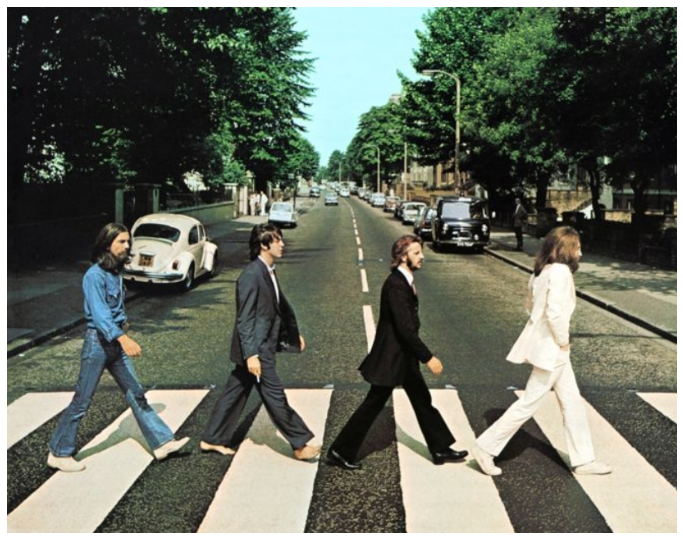

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy  as np
import os
%matplotlib inline

# 코랩 버전은 상대 경로를 사용하지 않습니다. /content 디렉토리를 기준으로 절대 경로를 이용합니다. 
# default_dir 은 /content/Computer-Vision로 지정하고 os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_dir = '/content/Computer-Vision'
img = cv2.imread(os.path.join(default_dir,'data/image/beatles01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img_rgb)


In [5]:
# Tensorflow의 Object Detection 모델 Weight인 frozen_inference_graph와 graph.pbtxt를 
# 이용하여 Opencv 의 dnn Network 모델로 로딩

In [6]:
#코랩 버전은 default_mask_dir 절대 경로를 이용합니다. os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_mask_dir='/content/Computer-Vision/Segmentation/mask_rcnn'
cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'),
                                       os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt'))

blob = cv2.dnn.blobFromImage(img , swapRB=True, crop=False)
cv_net.setInput(blob)

# Bounding box 정보는 detection_out_final layer에서 mask 정보는 detection_masks layer에서 추출. 
boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

In [7]:
layer_names = cv_net.getLayerNames()
layer_names

['Preprocessor/mul',
 'Preprocessor/sub',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d/depthwise',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/Relu',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/MaxPool_2a_3x3/MaxPool',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Conv2D',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Relu',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/Conv2D',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/Relu',
 'FirstStageFeatureExtractor/InceptionV2/I

In [8]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}



#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

In [9]:
print('boxes shape:', boxes.shape, 'masks shape:', masks.shape)
#number of objects, COCO class, mask, mask  

boxes shape: (1, 1, 100, 7) masks shape: (100, 90, 15, 15)


#### Detect된 Object에 대해서 bounding box와 mask를 시각화 
* 이미지를 mask 설명을 위해서 Detected된 모든 object를 시각화 하지 않고 단 하나의 object만 시각화 수행(iteration을 한번만 수행)

In [10]:
numClasses = masks.shape[1]
numDetections = boxes.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한 
# 별도의 image array 생성. 
draw_img = img.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

green_color=(0, 255, 0)
red_color=(0, 0, 255)

# 이미지를 mask 설명을 위해서 iteration을 한번만 수행. 
#for i in range(numDetections):
for i in range(1):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출. 
        # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
        classMask = mask[classId]
        print('Detect된 classMask shape:', classMask.shape)
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        print('원본 이미지 비율로 scale out된 classMask shape:', scaled_classMask.shape)
        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
        s_mask_b = (scaled_classMask > mask_threshold)
        print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              'scaled mask true shape:',s_mask_b[s_mask_b==True].shape, 
              'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)
        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)

Detect된 classMask shape: (15, 15)
원본 이미지 비율로 scale out된 classMask shape: (284, 140)
scaled mask shape: (284, 140) scaled mask pixel count: 39760 scaled mask true shape: (19429,) scaled mask False shape: (20331,)
before_mask_roi: (284, 140, 3)


In [11]:
s_mask_b

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

####  Detected된 object에 mask 적용 후 시각화

In [12]:
vis_mask = (s_mask_b * 255).astype("uint8")
print(vis_mask.shape, vis_mask[vis_mask >= 1], vis_mask[vis_mask >= 1].shape)
#Open CV로 원본 Object에 masking 작업 수행
instance = cv2.bitwise_and(before_mask_roi, before_mask_roi, mask=vis_mask)

(284, 140) [255 255 255 ... 255 255 255] (19429,)


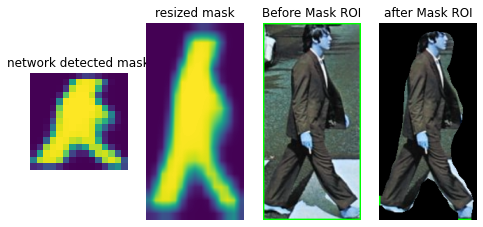

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(8, 8), ncols=4, nrows=1)

ax1.set_title('network detected mask')
ax1.axis('off')
ax1.imshow(classMask)

ax2.set_title('resized mask')
ax2.axis('off')
ax2.imshow(scaled_classMask)


ax3.set_title('Before Mask ROI')
ax3.axis('off')
ax3.imshow(before_mask_roi)

ax4.set_title('after Mask ROI')
ax4.axis('off')
ax4.imshow(instance)

#### Detected된 object에 mask를 특정 투명 컬러로 적용후 시각화

[255, 255, 0]


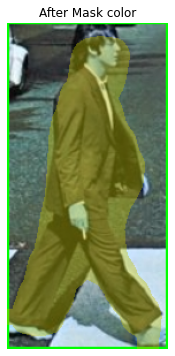

In [14]:
# Comment the above line and uncomment the two lines below to generate different instance colors
colorIndex = np.random.randint(0, len(colors)-1)
color = colors[colorIndex]
print(color)
after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
#투명한 효과를 내기 위해 값을 살짝 줄였습니다.

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])


#### Detect된 Object에 contour 윤곽선 적용. 

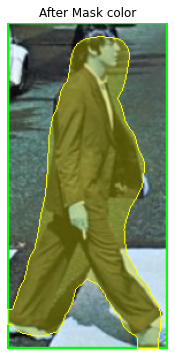

In [15]:
s_mask_i = s_mask_b.astype(np.uint8)
# https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539/ 에 이미지 컨투어 설명 있음 
contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])

#### Detected된 Object들에 Mask 하여 시각화 

Detect된 classMask shape: (15, 15)
원본 이미지 비율로 scale out된 classMask shape: (284, 140)
scaled mask shape: (284, 140) scaled mask pixel count: 39760 scaled mask true shape: (19429,) scaled mask False shape: (20331,)
before_mask_roi: (284, 140, 3)
Detect된 classMask shape: (15, 15)
원본 이미지 비율로 scale out된 classMask shape: (320, 151)
scaled mask shape: (320, 151) scaled mask pixel count: 48320 scaled mask true shape: (19727,) scaled mask False shape: (28593,)
before_mask_roi: (320, 151, 3)
Detect된 classMask shape: (15, 15)
원본 이미지 비율로 scale out된 classMask shape: (296, 178)
scaled mask shape: (296, 178) scaled mask pixel count: 52688 scaled mask true shape: (17478,) scaled mask False shape: (35210,)
before_mask_roi: (296, 178, 3)
Detect된 classMask shape: (15, 15)
원본 이미지 비율로 scale out된 classMask shape: (293, 163)
scaled mask shape: (293, 163) scaled mask pixel count: 47759 scaled mask true shape: (17652,) scaled mask False shape: (30107,)
before_mask_roi: (293, 163, 3)
Detect된 classMask shape: (15

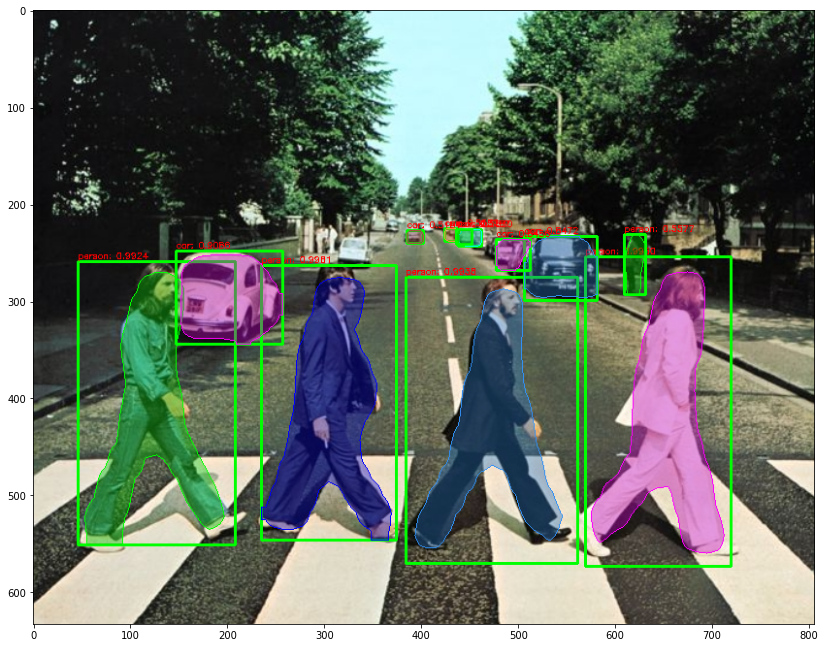

In [16]:
numClasses = masks.shape[1]
numDetections = boxes.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한 
# 별도의 image array 생성. 
draw_img = img.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]
conf_threshold = 0.5
mask_threshold = 0.3

green_color=(0, 255, 0)
red_color=(0, 0, 255)

for i in range(numDetections):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출. 
        # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
        classMask = mask[classId]
        print('Detect된 classMask shape:', classMask.shape)
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        print('원본 이미지 비율로 scale out된 classMask shape:', scaled_classMask.shape)
        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
        s_mask_b = (scaled_classMask > mask_threshold)
        print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              'scaled mask true shape:',s_mask_b[s_mask_b==True].shape, 
              'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)

        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)
        # Detect된 Object에 mask를 특정 투명 컬러로 적용. 
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
        draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        # Detect된 Object에 윤곽선(contour) 적용. 
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(14, 14))
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### 단일 image Segmentation 함수 생성. 

In [17]:
def get_box_info(box, img_width, img_height):
    
    classId = int(box[1])
    left = int(img_width * box[3])
    top = int(img_height * box[4])
    right = int(img_width * box[5])
    bottom = int(img_height * box[6])
    
    left = max(0, min(left, img_width - 1))
    top = max(0, min(top, img_height - 1))
    right = max(0, min(right, img_width - 1))
    bottom = max(0, min(bottom, img_height - 1))
    
    return classId, left, top, right, bottom

    
def draw_box(img_array, box, img_width, img_height, is_print=False):
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    score = box[2]
    classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
    text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
    
    if is_print:
        print("box:", box, "score:", score, "classId:", classId)
    
    cv2.rectangle(img_array, (left, top), (right, bottom), green_color, thickness=2 )
    cv2.putText(img_array, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, thickness=1)
    
    return img_array
    
def draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=False):
        
        classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
        classMask = mask[classId]
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        s_mask_b = (scaled_classMask > mask_threshold)
        before_mask_roi = img_array[top:bottom+1, left:right+1]
        
        # mask를 적용할 bounding box 영역의 image 추출하고 투명 color 적용. 
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = img_array[top:bottom+1, left:right+1][s_mask_b]
        img_array[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        # Detect된 Object에 윤곽선(contour) 적용. 
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_array[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)
        
        return img_array

In [18]:
import time

def detect_image_mask_rcnn(cv_net, img_array, conf_threshold, mask_threshold, use_copied_array, is_print=False):
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
        
    start_time = time.time()
    
    blob = cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False)
    cv_net.setInput(blob)
    boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])
    
    inference_time = time.time() - start_time
    if is_print:
        print('Segmentation Inference time {0:}'.format(inference_time))

    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    img_height = img_array.shape[0]
    img_width = img_array.shape[1]
    
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        #print("score:", score)
        if score > conf_threshold:
            draw_box(img_array , box, img_width, img_height, is_print=is_print)
            draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=is_print)
    
    return img_array

In [19]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

#### 다른 이미지 파일에 Segmentation 수행하기

Segmentation Inference time 6.267407417297363
box: [0.         0.         0.99785644 0.04259912 0.42621598 0.2566381
 0.93009853] score: 0.99785644 classId: 0
box: [0.         0.         0.9975453  0.43244976 0.2681948  0.67852885
 0.8399701 ] score: 0.9975453 classId: 0
box: [0.         0.         0.9971505  0.23768517 0.5497621  0.45513436
 0.94894993] score: 0.9971505 classId: 0
box: [ 0.         39.          0.9102633   0.44959113  0.63386905  0.5190123
  0.7239938 ] score: 0.9102633 classId: 39
box: [ 0.         38.          0.8011296   0.6458585   0.46479815  0.8204287
  0.5484391 ] score: 0.8011296 classId: 38


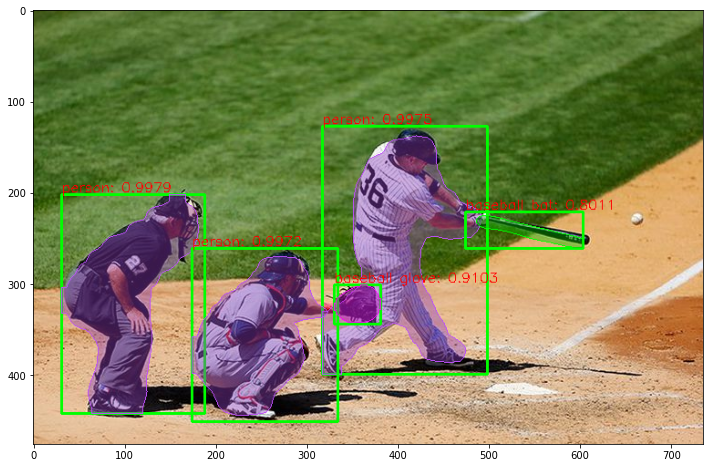

In [20]:
default_dir = '/content/Computer-Vision'
img = cv2.imread(os.path.join(default_dir,'data/image/baseball01.jpg'))

cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'),
                                       os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt'))

img_detected = detect_image_mask_rcnn(cv_net, img, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)


#### 다른 이미지 파일에 Segmentation 수행하기

Segmentation Inference time 6.475301027297974
box: [0.         2.         0.99316037 0.00976764 0.50575686 0.24784806
 1.        ] score: 0.99316037 classId: 2
box: [0.         2.         0.9556792  0.68818885 0.55631506 0.9870016
 0.965134  ] score: 0.9556792 classId: 2
box: [0.         2.         0.9139735  0.22216998 0.54377466 0.47355217
 0.9328497 ] score: 0.9139735 classId: 2
box: [0.         0.         0.57199544 0.5869654  0.6460411  0.6634694
 0.88133675] score: 0.57199544 classId: 0
box: [0.         0.         0.55455947 0.44299066 0.25379553 0.6032686
 0.92294955] score: 0.55455947 classId: 0


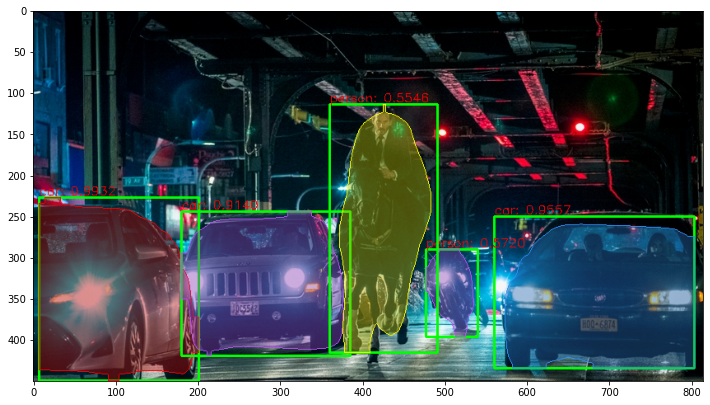

In [21]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

default_dir = '/content/Computer-Vision'
wick_img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))

wick_img_detected = detect_image_mask_rcnn(cv_net, wick_img, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, is_print=True)

wick_img_rgb = cv2.cvtColor(wick_img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(wick_img_rgb)

#### 영상에 Segmentation 적용

In [22]:
def detect_video_mask_rcnn(cv_net, input_path, output_path, conf_threshold, mask_threshold,  is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, 24, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    frame_index=0
    while True:
        hasFrame, img_frame = cap.read()
        frame_index += 1
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        print("frame index:{0:}".format(frame_index), end=" ")
        returned_frame = detect_image_mask_rcnn(cv_net, img_frame, conf_threshold=conf_threshold,
                                                mask_threshold=mask_threshold,use_copied_array=False, is_print=is_print)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [23]:
cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'),
                                       os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt'))

detect_video_mask_rcnn(cv_net, os.path.join(default_dir, 'data/video/John_Wick_small.mp4'), 
                       os.path.join(default_dir, 'data/output/John_Wick_mask_01.avi'),
                      conf_threshold=0.5, mask_threshold=0.3, is_print=True)

총 Frame 갯수: 58
frame index:1 Segmentation Inference time 6.717744827270508
box: [0.         2.         0.9897792  0.86242795 0.3607605  0.99989486
 0.8309683 ] score: 0.9897792 classId: 2
box: [0.         2.         0.9701173  0.         0.29770768 0.16895674
 0.7383983 ] score: 0.9701173 classId: 2
box: [0.         2.         0.9561754  0.1257114  0.3801416  0.40036446
 0.75959766] score: 0.9561754 classId: 2
box: [0.         2.         0.9518076  0.75568426 0.5090503  0.85527325
 0.7149634 ] score: 0.9518076 classId: 2
box: [0.         2.         0.7611337  0.7179851  0.53895617 0.78393286
 0.6857109 ] score: 0.7611337 classId: 2
box: [0.         0.         0.5549664  0.41242653 0.01324424 0.6135618
 0.6925204 ] score: 0.5549664 classId: 0
box: [0.         0.         0.5201011  0.65576553 0.4179829  0.72486687
 0.63431793] score: 0.5201011 classId: 0
frame index:2 Segmentation Inference time 6.502910852432251
box: [0.         2.         0.9903397  0.8629229  0.36098033 0.9998951
 0.8

In [24]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/Computer-Vision/data/output/John_Wick_mask_01.avi '/content/gdrive/My Drive/John_Wick_mask_01.avi'